<a href="https://colab.research.google.com/github/purrvaja/Anomaly-Detection-in-FX-data/blob/main/anomaly_in_fx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import libararies

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import requests
import json
import io

from sklearn.ensemble import IsolationForest

import warnings
warnings.filterwarnings('ignore')

## Retreiving the exchange rate data from the European Central Bank (ECB) data portal - using the ECB API



*   All currencies against the EUR
*   2013 - 2023 (Monthly)
* https://data.ecb.europa.eu/help/api/data



In [2]:
# building the URL

entrypoint = 'https://data-api.ecb.europa.eu/service/'
resource = 'data'
flowRef = 'EXR'
key = 'M..EUR.SP00.A'


# define the parameters
parameters = {
    'startPeriod': '2013-01',
    'endPeriod': '2023-12',
    'format': 'csvdata'
}

In [3]:
# Construct the URL
request_url = entrypoint + resource + '/' + flowRef + '/' + key

# Make the HTTPS request
response = requests.get(request_url, params = parameters)

In [4]:
print(response)
print(response.url)

<Response [200]>
https://data-api.ecb.europa.eu/service/data/EXR/M..EUR.SP00.A?startPeriod=2013-01&endPeriod=2023-12&format=csvdata


In [12]:
# Viewing the first 1000 characters
response.text[0:1000]

'KEY,FREQ,CURRENCY,CURRENCY_DENOM,EXR_TYPE,EXR_SUFFIX,TIME_PERIOD,OBS_VALUE,OBS_STATUS,OBS_CONF,OBS_PRE_BREAK,OBS_COM,TIME_FORMAT,BREAKS,COLLECTION,COMPILING_ORG,DISS_ORG,DOM_SER_IDS,PUBL_ECB,PUBL_MU,PUBL_PUBLIC,UNIT_INDEX_BASE,COMPILATION,COVERAGE,DECIMALS,NAT_TITLE,SOURCE_AGENCY,SOURCE_PUB,TITLE,TITLE_COMPL,UNIT,UNIT_MULT\r\nEXR.M.ARS.EUR.SP00.A,M,ARS,EUR,SP00,A,2013-01,6.5749363636364,A,,,Indicative rate,P1M,,A,,,,,,,,,,5,,4F0,,Argentine peso/Euro,"Indicative exchange rate, Argentine peso/Euro, 2:15 pm (C.E.T.)",ARS,0\r\nEXR.M.ARS.EUR.SP00.A,M,ARS,EUR,SP00,A,2013-02,6.68904,A,,,Indicative rate,P1M,,A,,,,,,,,,,5,,4F0,,Argentine peso/Euro,"Indicative exchange rate, Argentine peso/Euro, 2:15 pm (C.E.T.)",ARS,0\r\nEXR.M.ARS.EUR.SP00.A,M,ARS,EUR,SP00,A,2013-03,6.5896,A,,,Indicative rate,P1M,,A,,,,,,,,,,5,,4F0,,Argentine peso/Euro,"Indicative exchange rate, Argentine peso/Euro, 2:15 pm (C.E.T.)",ARS,0\r\nEXR.M.ARS.EUR.SP00.A,M,ARS,EUR,SP00,A,2013-04,6.7090095238095,A,,,Indicative rate,P1M

In [5]:
# Loading the response into a dataframe
df = pd.read_csv(io.StringIO(response.text))
df.head()

,KEY,FREQ,CURRENCY,CURRENCY_DENOM,EXR_TYPE,EXR_SUFFIX,TIME_PERIOD,OBS_VALUE,OBS_STATUS,OBS_CONF,...,COMPILATION,COVERAGE,DECIMALS,NAT_TITLE,SOURCE_AGENCY,SOURCE_PUB,TITLE,TITLE_COMPL,UNIT,UNIT_MULT
0,EXR.M.ARS.EUR.SP00.A,M,ARS,EUR,SP00,A,2013-01,6.574936,A,NaN,...,NaN,NaN,5,NaN,4F0,NaN,Argentine peso/Euro,"Indicative exchange rate, Argentine peso/Euro,...",ARS,0
1,EXR.M.ARS.EUR.SP00.A,M,ARS,EUR,SP00,A,2013-02,6.689040,A,NaN,...,NaN,NaN,5,NaN,4F0,NaN,Argentine peso/Euro,"Indicative exchange rate, Argentine peso/Euro,...",ARS,0
2,EXR.M.ARS.EUR.SP00.A,M,ARS,EUR,SP00,A,2013-03,6.589600,A,NaN,...,NaN,NaN,5,NaN,4F0,NaN,Argentine peso/Euro,"Indicative exchange rate, Argentine peso/Euro,...",ARS,0
3,EXR.M.ARS.EUR.SP00.A,M,ARS,EUR,SP00,A,2013-04,6.709010,A,NaN,...,NaN,NaN,5,NaN,4F0,NaN,Argentine peso/Euro,"Indicative exchange rate, Argentine peso/Euro,...",ARS,0
4,EXR.M.ARS.EUR.SP00.A,M,ARS,EUR,SP00,A,2013-05,6.796432,A,NaN,...,NaN,NaN,5,NaN,4F0,NaN,Argentine peso/Euro,"Indicative exchange rate, Argentine peso/Euro,...",ARS,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4541 entries, 0 to 4540
Data columns (total 32 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   KEY              4541 non-null   object 
 1   FREQ             4541 non-null   object 
 2   CURRENCY         4541 non-null   object 
 3   CURRENCY_DENOM   4541 non-null   object 
 4   EXR_TYPE         4541 non-null   object 
 5   EXR_SUFFIX       4541 non-null   object 
 6   TIME_PERIOD      4541 non-null   object 
 7   OBS_VALUE        4541 non-null   float64
 8   OBS_STATUS       4541 non-null   object 
 9   OBS_CONF         4129 non-null   object 
 10  OBS_PRE_BREAK    0 non-null      float64
 11  OBS_COM          470 non-null    object 
 12  TIME_FORMAT      4541 non-null   object 
 13  BREAKS           0 non-null      float64
 14  COLLECTION       4541 non-null   object 
 15  COMPILING_ORG    0 non-null      float64
 16  DISS_ORG         0 non-null      float64
 17  DOM_SER_IDS   

In [6]:
# making a separate dataframe with only the necessary cols
ts = df[['TIME_PERIOD', 'OBS_VALUE', 'CURRENCY']]


# changing to datetime format
ts['TIME_PERIOD'] = pd.to_datetime(ts['TIME_PERIOD'])


ts.head()

,TIME_PERIOD,OBS_VALUE,CURRENCY
0,2013-01-01,6.574936,ARS
1,2013-02-01,6.689040,ARS
2,2013-03-01,6.589600,ARS
3,2013-04-01,6.709010,ARS
4,2013-05-01,6.796432,ARS


In [ ]:
# Get unique currencies
unique_currencies = ts['CURRENCY'].unique()

### Facet Plot of the exchange rates of 38 unique currencies (against the EUR) over time

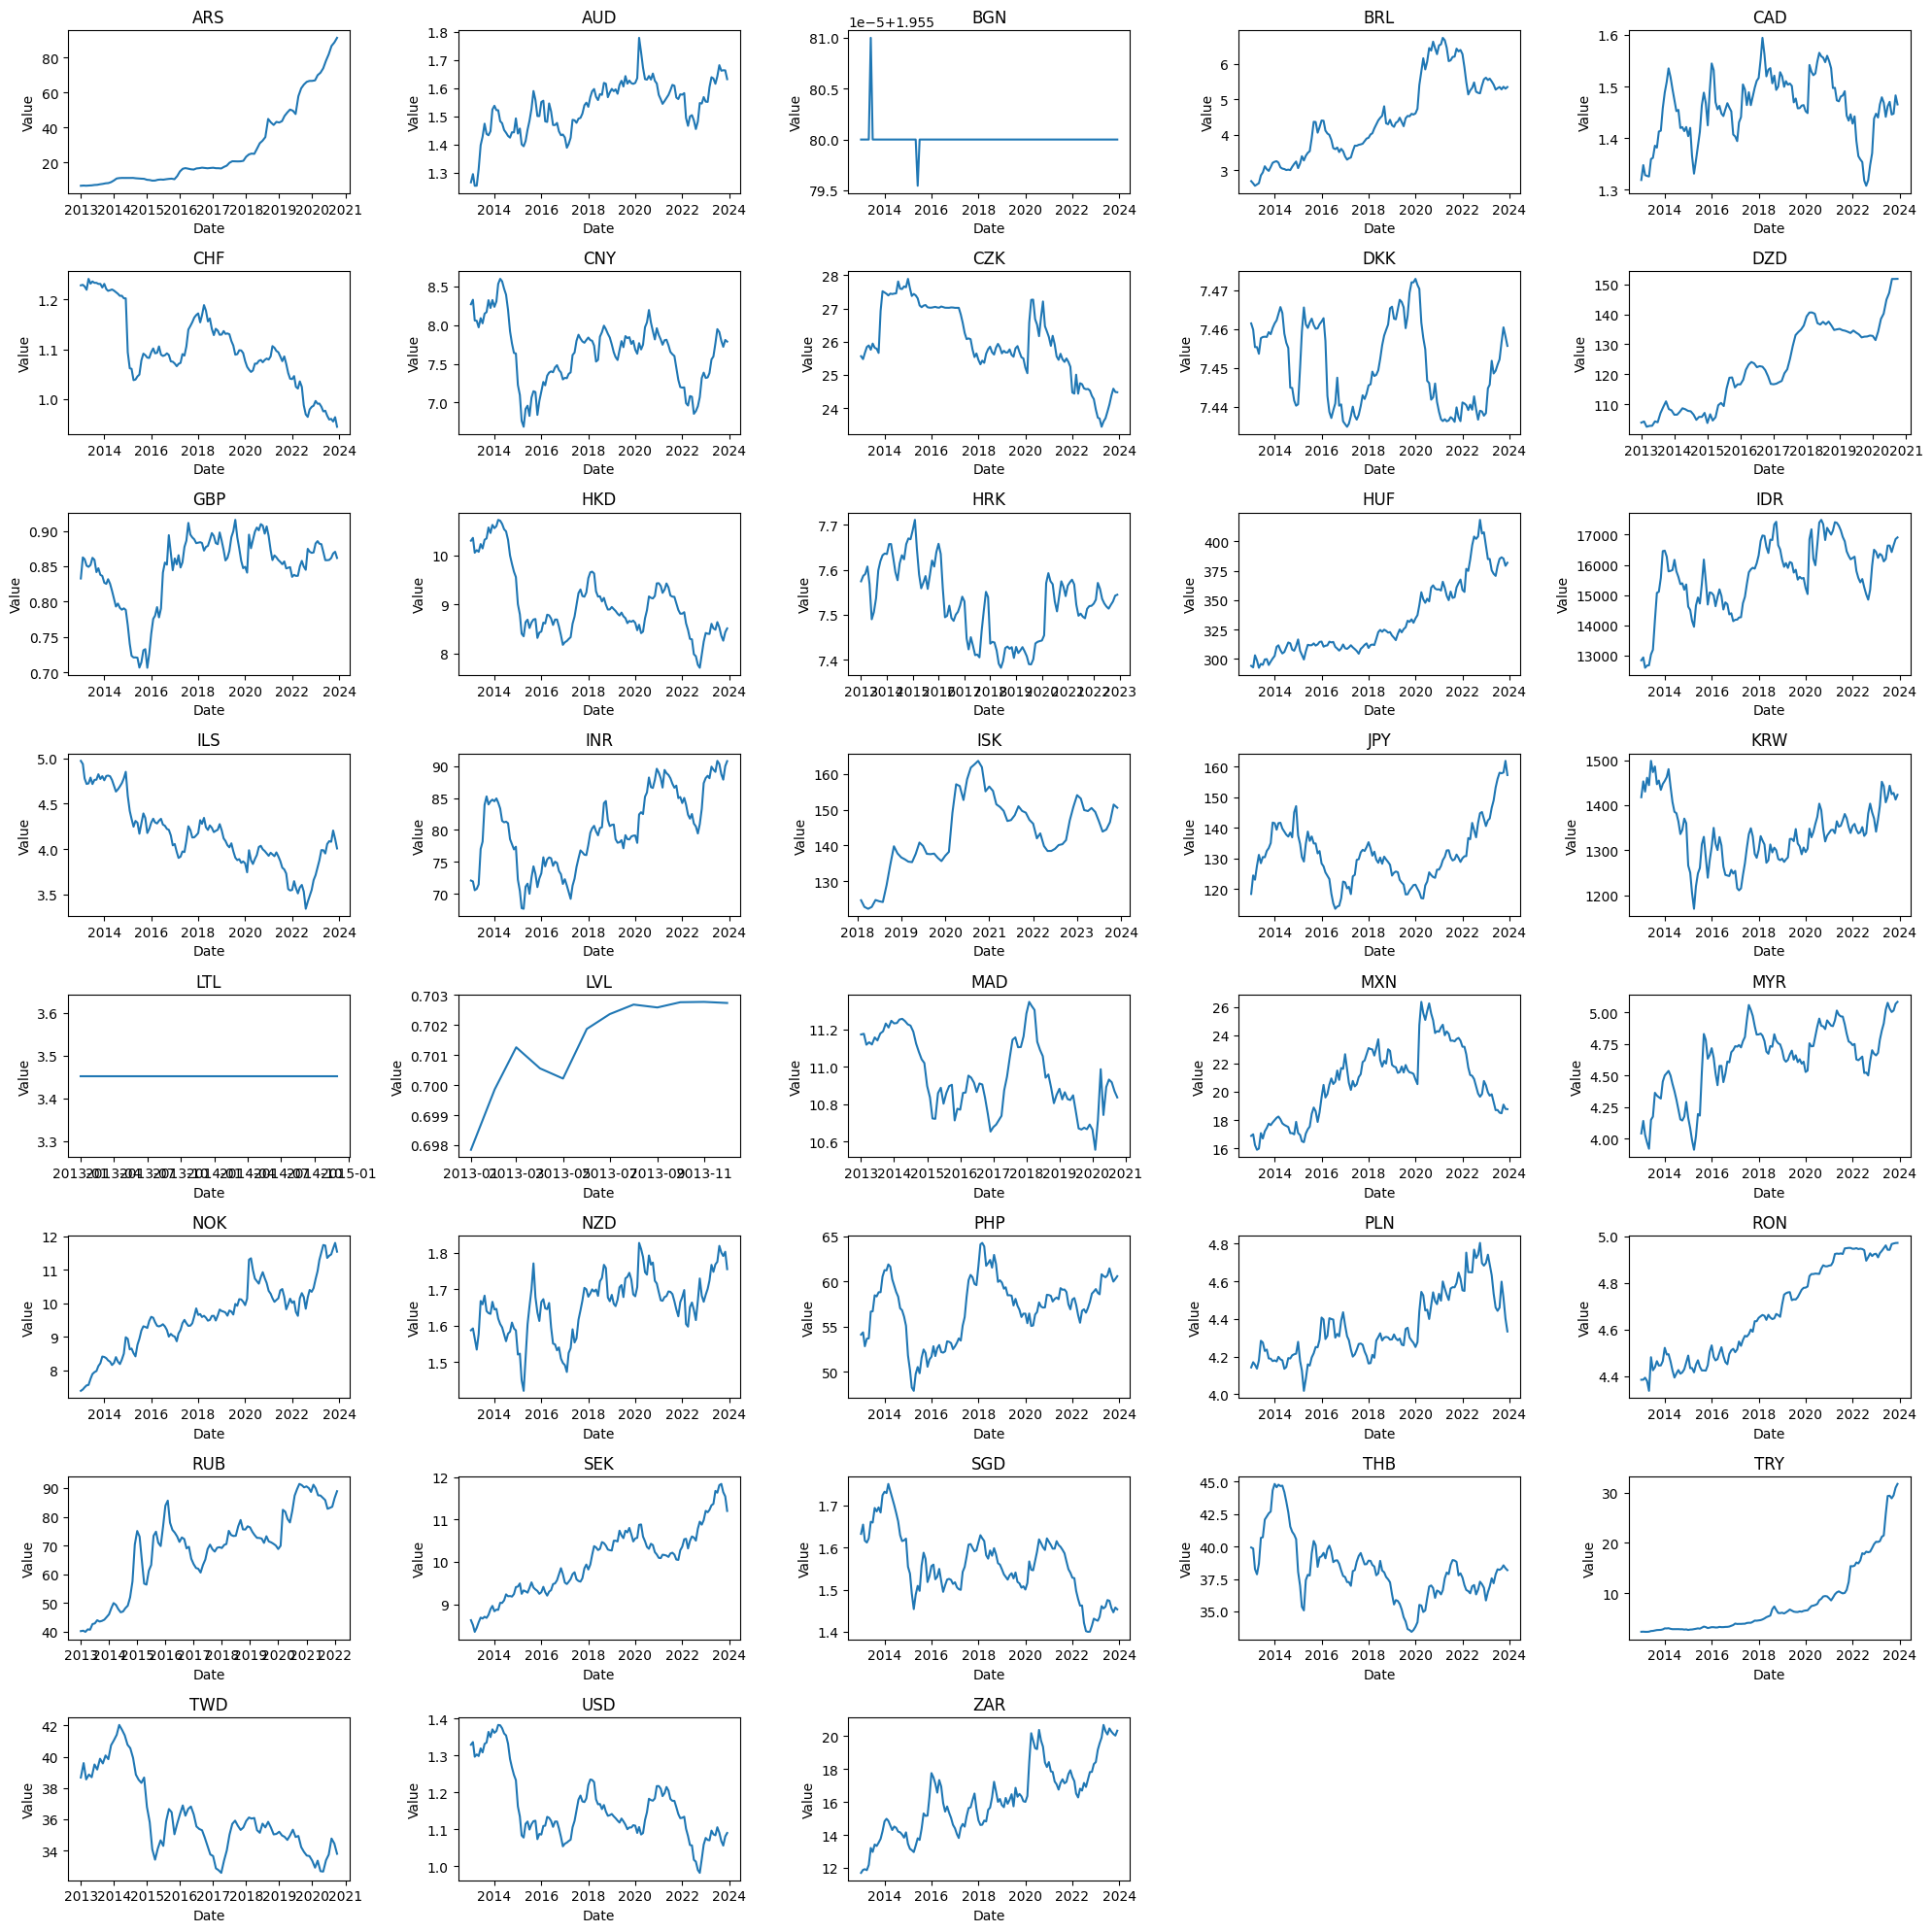

In [16]:
# Create a figure and axis objects
fig, axes = plt.subplots(8, 5, figsize=(20, 20), sharex=False, sharey=False)

axes = axes.flatten()

# Iterate over unique currencies and plot them on separate subplots
for i, currency in enumerate(unique_currencies):
    currency_data = ts[ts['CURRENCY'] == currency]
    ax = axes[i]
    sns.lineplot(data=currency_data, x='TIME_PERIOD', y='OBS_VALUE', ax=ax)
    ax.set_title(currency)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')

# Hide any remaining unused subplots
for i in range(len(unique_currencies), len(axes)):
    axes[i].axis('off')


plt.tight_layout()
plt.show()



*   LTL (Lithuanian litas) - Jan 2015 onwards Lithuania adapted the EUR as its official currency
*   LVL (Latvian lats) - Jan 2014 onwards Latvia adapted the EUR as its official currency

The reason why data is only available until 2015/2014 for the above currencies, and its odd charts


### Currency Correlations - the extent to which currrency pairs move toghether

In [ ]:
# Pivot the DataFrame to have currencies as columns and dates as rows
pivot_df = ts.pivot(index='TIME_PERIOD', columns='CURRENCY', values='OBS_VALUE')

In [69]:

# Calculate the correlation matrix
correlation_matrix = pivot_df.corr()

# Create the heatmap figure
fig = go.Figure(data=go.Heatmap(
    z=correlation_matrix.values,
    x=correlation_matrix.columns,
    y=correlation_matrix.index,
    colorscale='RdBu',  # You can choose other colorscales as well
    zmin=-1,
    zmax=1
))

# Update layout
fig.update_layout(
    title="Correlation Heatmap of Currencies",
    xaxis_title="Currency",
    yaxis_title="Currency"
)

# Show plot
fig.show()

In [75]:
correlation_matrix

#indices of highly correlated pairs
highly_correlated_pairs = (correlation_matrix.abs() > 0.5) & (correlation_matrix < 1)

#creating a df to store the highly correlated pairs and their correlation values
correlation_table = pd.DataFrame(columns=['Currency 1', 'Currency 2', 'Absolute Correlation'])


# Iterate through the indices and extract highly correlated pairs
for var1 in correlation_matrix.columns:
  for var2 in correlation_matrix.columns:
      if highly_correlated_pairs.loc[var1, var2]:
          correlation_table = correlation_table.append({
                    'Currency 1': var1,
                    'Currency 2': var2,
                    'Absolute Correlation': correlation_matrix.loc[var1, var2]
                }, ignore_index=True)


# Filter the table to show only highly correlated pairs with correlation > 0.5
correlation_table = correlation_table[correlation_table['Absolute Correlation'].abs() > 0.5]

# Sort the table by correlation values in descending order
correlation_table = correlation_table.iloc[abs(correlation_table['Absolute Correlation']).argsort()[::-1]]
correlation_table = correlation_table.reset_index()

# Drop alternate rows based on index positions (since each pair has 2 rows)
drop = range(1, len(correlation_table), 2)
correlation_table = correlation_table.drop(drop)

correlation_table = correlation_table.reset_index(drop=True)
correlation_table.drop(['index'], axis=1, inplace=True)


correlation_table.head(10)

,Currency 1,Currency 2,Absolute Correlation
0,HKD,USD,0.998572
1,TRY,ARS,0.959001
2,ARS,RON,0.938419
3,NOK,ZAR,0.934733
4,DZD,MXN,0.934580
5,USD,SGD,0.932674
6,HUF,ARS,0.931811
7,HKD,SGD,0.927499
8,ILS,TWD,0.926214
9,USD,TWD,0.921224




*   HKD/USD have the highest correlation since the Hong Kong Dollar is pegged to the USD.
*   Countries with geographical proximity and similar economic conditions tend to be positively correlated.



## Anomaly Detection

Isolation forest algorithm:

Detects anomalies by looking for data points that are "isolated" or easily separated from the rest. It randomly splits the data into smaller groups, and points needing fewer splits are considered more likely anomalies, as they're different and easier to isolate.



In [ ]:
"""
model parameters:
contamination -- threshold for anomalies/ the anticipated proportion of anomalies in the dataset (higher value means less sensitive to anomalies and vice versa)
bootstrap = True -- random samples are drawn with replacement
max_samples -- The number of samples to draw from X to train each base estimator


"""

In [36]:
# Function to train seperate models for each currency


def isolation_forest(currency):
  currency_df = ts[ts['CURRENCY'] == currency]

  # Define and fit the model
  model = IsolationForest(contamination=0.05, max_samples=0.2, bootstrap=True)
  model.fit(currency_df[['OBS_VALUE']])

  # Score the data and obtain anomaly scores
  currency_df['scores'] = model.decision_function(currency_df[['OBS_VALUE']])
  currency_df['anomaly_score'] = model.predict(currency_df[['OBS_VALUE']])

  return currency_df


In [38]:
anomaly_df = pd.DataFrame()

for currency in unique_currencies:
  currency_df = isolation_forest(currency)

  anomaly_df = pd.concat([anomaly_df, currency_df], ignore_index=True)

In [39]:
# anomaly score = 1 --> not an anomaly
# anomaly score = -1 --> anomaly

anomaly_df

,TIME_PERIOD,OBS_VALUE,CURRENCY,scores,anomaly_score
0,2013-01-01,6.574936,ARS,0.115065,1
1,2013-02-01,6.689040,ARS,0.118128,1
2,2013-03-01,6.589600,ARS,0.115065,1
3,2013-04-01,6.709010,ARS,0.120572,1
4,2013-05-01,6.796432,ARS,0.119698,1
...,...,...,...,...,...
4536,2023-08-01,20.472335,ZAR,-0.002978,-1
4537,2023-09-01,20.277986,ZAR,0.006521,1
4538,2023-10-01,20.138950,ZAR,0.009640,1
4539,2023-11-01,20.039686,ZAR,0.015674,1


### Facet plot highlighting the anomalies detected by the algorithm

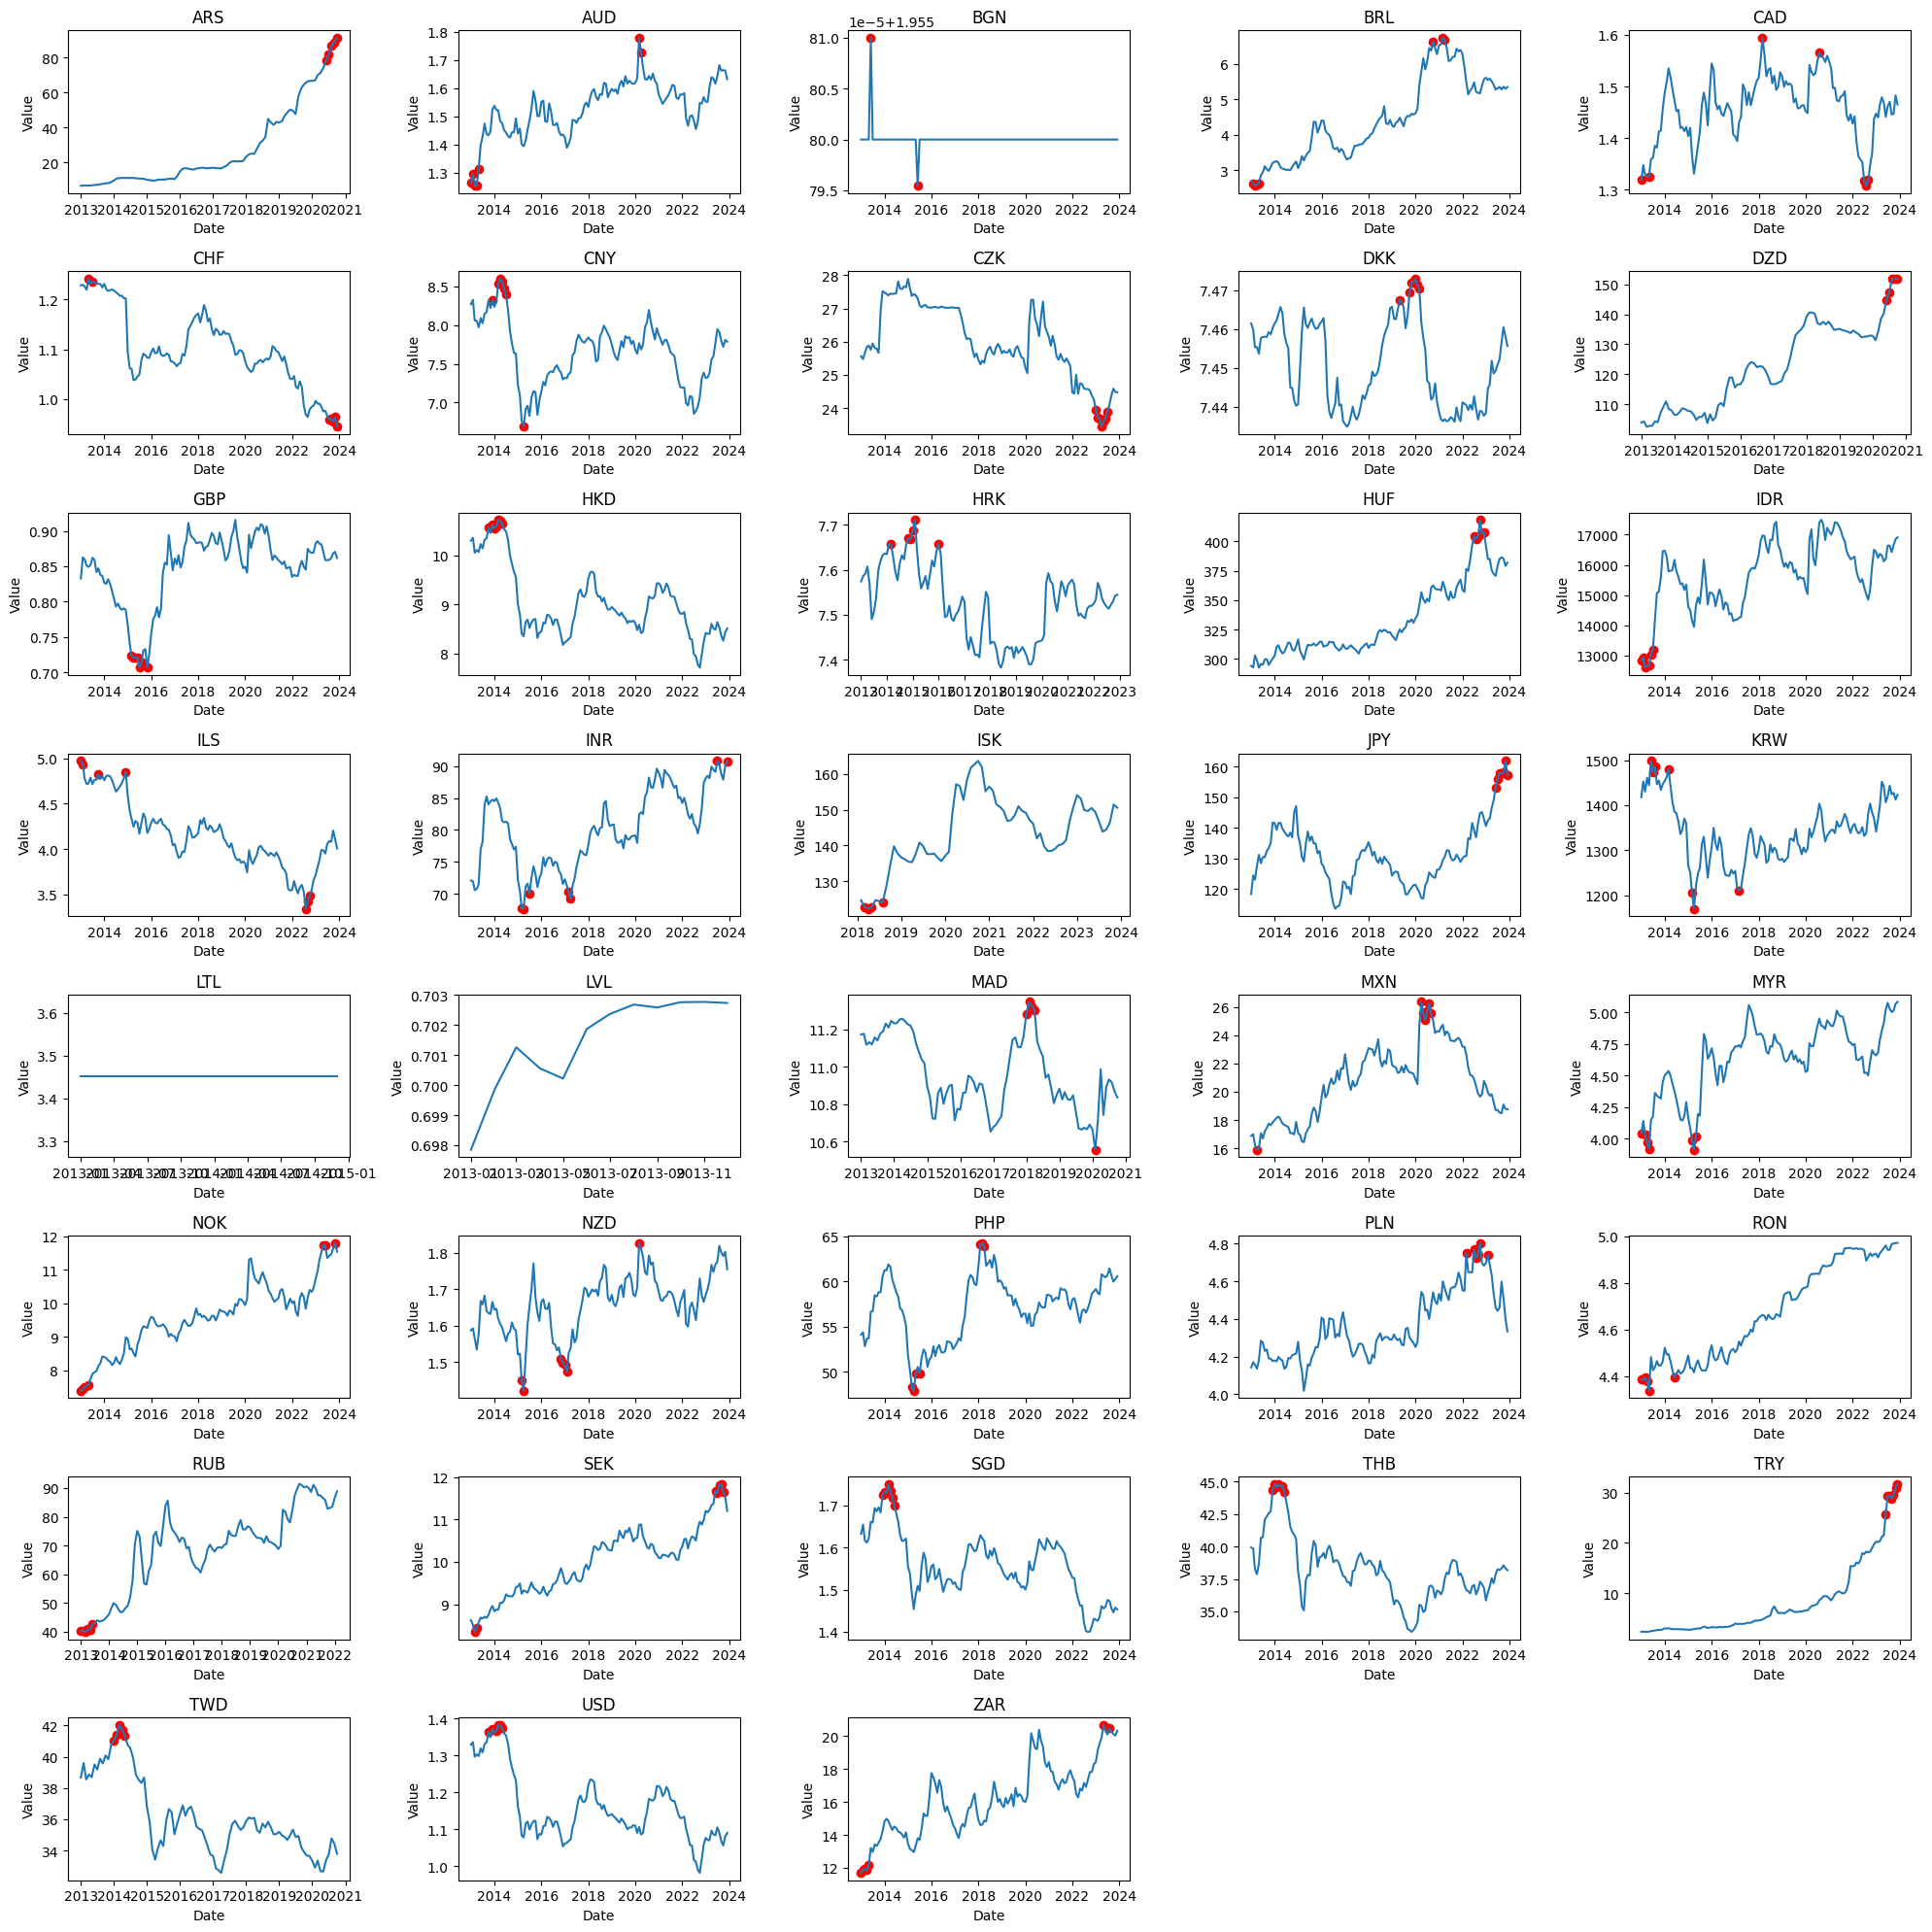

In [43]:
# Create a figure and axis objects
fig, axes = plt.subplots(8, 5, figsize=(20, 20), sharex=False, sharey=False)

# Flatten the axes array for easier iteration
axes = axes.flatten()


# Iterate over unique currencies and plot them on separate subplots
for i, currency in enumerate(unique_currencies):
    currency_data = anomaly_df[anomaly_df['CURRENCY'] == currency]
    ax = axes[i]
    #ax.scatter(currency_data['TIME_PERIOD'],currency_data['OBS_VALUE'],
    #           c=['blue' if x == 1 else 'red' for x in currency_data['anomaly_score']])
    ax.scatter(currency_data[currency_data['anomaly_score'] == -1]['TIME_PERIOD'],
               currency_data[currency_data['anomaly_score'] == -1]['OBS_VALUE'], c = 'red')
    ax.plot(currency_data['TIME_PERIOD'],currency_data['OBS_VALUE'])


    #sns.lineplot(data=currency_data, x='TIME_PERIOD', y='OBS_VALUE', ax=ax)
    ax.set_title(currency)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')

# Hide any remaining unused subplots
for i in range(len(unique_currencies), len(axes)):
    axes[i].axis('off')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

Possible reasons for some of the anomalies above:


*   Fall of GBP in 2016 - Brexit
*   Fall of CAD in 2022 - Bank of Canada increasing interest rate to 3.75%
*   Hike of HKD in 2014 - Positive economic conditions, 2.3% increase in GDP
*   Hike of USD in 2014 - This reflects the EUR's fall against the USD, the biggest fall since 2005. Could've been due to the political instability in Greece, possible quantitative easing.


